In [1]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import datetime
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
questions = []
paras = []
para_match_precisions = []
para_match_recalls = []
para_match_f1s = []
with open('../input/cleaned/train_round_0.json') as f:
    for line in f:
        sample =json.loads(line.strip())
        for doc in sample['documents']:
            para_match_precisions.extend(doc['para_match_precisions'])
            para_match_recalls.extend(doc['para_match_recalls'])
            para_match_f1s.extend(doc['para_match_f1s'])
            
            questions.extend([sample['question']] * len(doc['paragraphs']))
            paras.extend(doc['paragraphs'])

In [3]:
para_match_score_df = pd.DataFrame()
para_match_score_df['question'] = questions
para_match_score_df['para'] = paras
para_match_score_df['para_match_precision'] = para_match_precisions
para_match_score_df['para_match_recall'] = para_match_recalls
para_match_score_df['para_match_f1'] = para_match_f1s

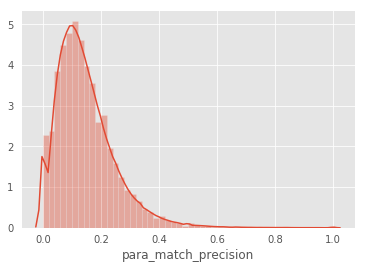

In [21]:
sns.distplot(para_match_score_df['para_match_precision'])
plt.show()

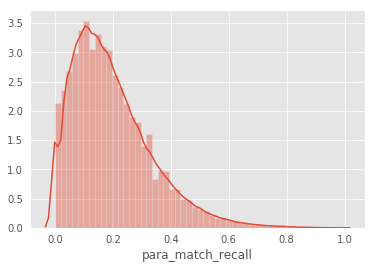

In [22]:
sns.distplot(para_match_score_df['para_match_recall'])
plt.show()

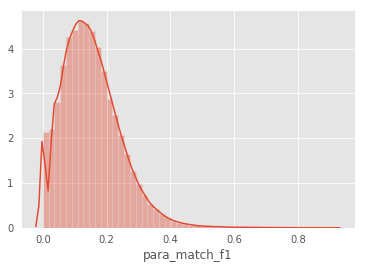

In [23]:
sns.distplot(para_match_score_df['para_match_f1'])
plt.show()

In [4]:
low_match_sent_df = para_match_score_df[para_match_score_df['para_match_recall'] == 0]

In [5]:
low_match_sent_df['para_len'] = low_match_sent_df['para'].map(len)

/home/lq/softwares/anaconda3/envs/tf12/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 统计不相关句子出现的次数

In [6]:
import psutil
from multiprocessing import Pool

num_partitions = 20  # number of partitions to split dataframe
num_cores = psutil.cpu_count()  # number of cores on your machine

print('number of cores:', num_cores)
def df_parallelize_run(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


number of cores: 32


In [7]:
from tqdm import tqdm
tqdm.pandas()

In [17]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
bleu_smoothing_function = SmoothingFunction().method1
import warnings
warnings.filterwarnings("ignore")

def bleu_4(ground_truths, prediction):
    """
    This function calculates and returns the bleu-4

    Args:
        ground_truths: references, list(list(str))
        prediction: hypothesis, list(str)
    """
    if len(prediction) == 0 and len(ground_truths) != 0 and sum([len(gt) for gt in ground_truths]) != 0:
        return 0

    bleu_score = sentence_bleu(ground_truths, prediction, smoothing_function=bleu_smoothing_function)
    return bleu_score


In [30]:
# bleu_4([['测试']], ['测试'])
reference = [['测试aaaa']]
candidate = ['测试aaaa']
bleu_4(reference, candidate)

0.1778279410038923

In [15]:
from nltk.translate.bleu_score import sentence_bleu

In [16]:
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [54]:
from utils.bleu import Bleu
from utils.precision_recall_f1 import precision_recall_f1

def para_question_match_score(paragraph, question):
    """
    计算 para 和 question 的匹配得分（最大覆盖率）
    为每个段落 i 计算问题与该段落的最大覆盖度，最大覆盖度采用 recall, 再计算该截取片段和问题的 bleu
    match_score = recall + bleu
    """
    paragraph = list(paragraph)
    question = list(question)

    best_recall = 0
    best_start_idx = -1
    best_end_idx = -1
    for start_idx in range(0, len(paragraph)):
        # 开始的词不在答案中，或者，开始的词为标点符号或splitter，直接过滤
        if paragraph[start_idx] not in question:
            continue

        for end_idx in range(len(paragraph) - 1, start_idx - 1, -1):
            if paragraph[end_idx] not in question:
                continue

            sub_para_content = paragraph[start_idx: end_idx + 1]
            # 计算该片段和 question 的 recall
            recall = precision_recall_f1(sub_para_content, question)[1]

            if recall > best_recall:
                best_recall = recall
                best_start_idx = start_idx
                best_end_idx = end_idx

    best_sub_para = paragraph[best_start_idx: best_end_idx + 1]
    best_sub_para = ''.join(best_sub_para)
    question = ''.join(question)
    # 计算匹配度最高情况下的 bleu4
    bleu4 = Bleu(4).add_inst(cand=best_sub_para, ref=question).get_score()
    best_match_score = best_recall + bleu4
    print(best_recall, bleu4)
    return best_match_score


In [55]:
question = "云南省军区扫雷指挥部扫雷二队官兵在云南河口瑶族自治县桥头乡薄竹箐雷场徒步验收的完成标志着什么？"
paragraph = "新华社昆明１２月９日电（记者李琰）９日上午，云南省军区扫雷指挥部扫雷二队官兵在云南河口瑶族自治县桥头乡薄竹箐雷场徒步验收完成，标志着云南省军区扫雷部队圆满完成中越边境红河段排雷任务。"
paragraph1 = "经过云南省军区扫雷指挥部扫雷二队官兵８个多月的奋战，中越边境红河段遗留的１８块雷场成功清除雷障，４．４３６平方公里“死亡地带”完成向“和平之地”的蜕变。"
paragraph2 = "徒步验收结束后，扫雷部队和地方政府的代表在土地移交文书上签字，并拆除了雷区封围标示牌。最后，军民共同在昔日的雷场中种下了象征和平的树苗。"


In [59]:
para_question_match_score(paragraph, question)

0.9148936170212766 0.5990390030185169


1.5139326200397933

In [62]:
para_question_match_score(paragraph1, question)

0.46808510638297873 0.2324380104806511


0.7005231168636299

In [63]:
from utils.rouge import RougeL


def para_pair_rougel(cand_para, ref_para):
    """
    计算连个段落间的 rouge 得分
    """
    return RougeL().add_inst(cand=cand_para, ref=ref_para).get_score()


In [66]:
para_pair_rougel(paragraph, paragraph1)

0.31650369187786864

In [67]:
para_pair_rougel(paragraph1, paragraph)

0.30641421947449765

In [72]:
def current_para_cross_paras_rougel(para_id, paras):
    """
    计算该 para 与该 doc 中其他 para 的 rougel 得分综合，用于评判该段落和其他段落的交互
    """
    cur_para = paras[para_id]

    rouge_ls = []
    for pid, para in enumerate(paras):
        if pid == para_id:
            continue

        # 计算两个段落间的 rouge 得分
        rougel = RougeL().add_inst(cand=para, ref=cur_para).get_score()
        rouge_ls.append(rougel)
    return sum(rouge_ls) / len(rouge_ls)


In [73]:
current_para_cross_paras_rougel(0, [paragraph, paragraph1, paragraph2])

0.22676016439962826